In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torchmetrics
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from matplotlib import pyplot as plt
import os
from pathlib import Path
from PIL import Image
from collections import defaultdict
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [3]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v2/'
dataset = CustomImageDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

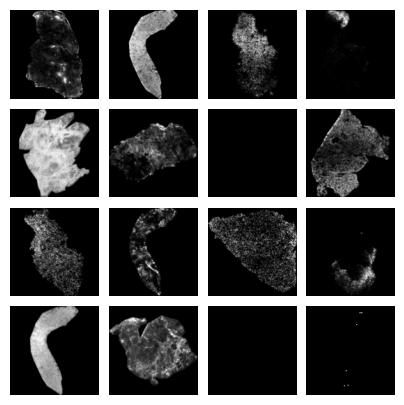

In [4]:
# Get a batch of 25 images for visualization
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Unpack images and labels
num_samples = 16
sample_images = [images[i, 0].numpy() for i in range(num_samples)]  # Convert images to numpy

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # For grayscale input
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Calculate the flattened size after convolutions
        self.flattened_shape, self.flattened_size = self._get_flattened_size(input_shape)
        
        # Encoder fully connected layers
        self.enc_fc1 = nn.Linear(self.flattened_size, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # Decoder fully connected layers
        self.dec_fc1 = nn.Linear(latent_dim, 128)
        self.dec_fc2 = nn.Linear(128, self.flattened_size)

        # Decoder convolutional layers
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def _get_flattened_size(self, input_shape):
        """Pass a dummy input through conv layers to determine the flattened size."""
        x = torch.zeros(1, *input_shape)  # Create a dummy input
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        flattened_shape = x.shape[1:]  # Save shape for reshaping in decoder
        flattened_size = x.numel()     # Total size after flattening
        return flattened_shape, flattened_size

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = x.view(-1, *self.flattened_shape)  # Dynamically reshape to match encoder output
        x = F.relu(self.dec_conv1(x))
        x = torch.sigmoid(self.dec_conv2(x))  # Output in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

In [13]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 10
epochs = 10
learning_rate = 1e-3

# Model, optimizer, and device setup
device = torch.device("cuda")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
epoch_times = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    start_time = time.time()  # Start timer for epoch
    
    for images, labels in dataloader:  # Assuming dataloader is your DataLoader for the images
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        
        # Compute loss
        loss = vae_loss(recon_images, images, mu, logvar)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    end_time = time.time()
    
    avg_loss = train_loss / len(dataloader)
    training_loss.append(avg_loss)
    
    # Calculate and store epoch duration
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Time: {epoch_duration:.2f} sec")

Epoch 1/10, Loss: 61041.2504, Time: 6.03 sec
Epoch 2/10, Loss: 45154.7220, Time: 6.12 sec
Epoch 3/10, Loss: 42887.1819, Time: 5.60 sec
Epoch 4/10, Loss: 42178.6435, Time: 5.87 sec
Epoch 5/10, Loss: 41823.0538, Time: 6.08 sec
Epoch 6/10, Loss: 41522.3072, Time: 6.07 sec
Epoch 7/10, Loss: 41325.6368, Time: 5.93 sec
Epoch 8/10, Loss: 41190.0167, Time: 6.97 sec
Epoch 9/10, Loss: 41094.2374, Time: 7.12 sec
Epoch 10/10, Loss: 40988.8572, Time: 7.44 sec


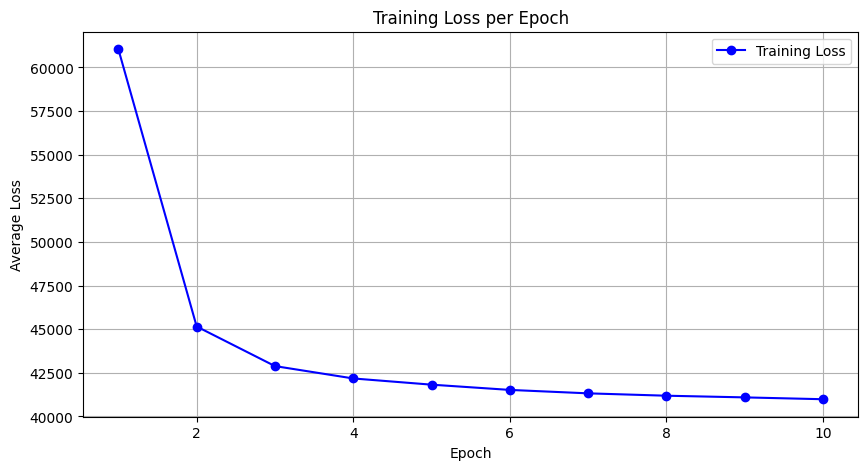

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

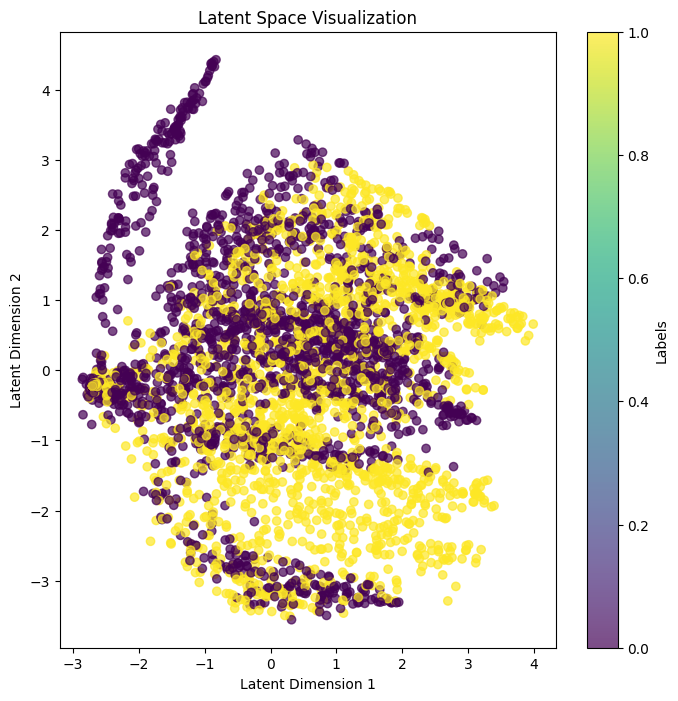

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

def visualize_latent_space(model, dataloader, latent_dim=2, use_tsne=False):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use the mean for visualization
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    if latent_dim > 2:
        if use_tsne:
            latents_2d = TSNE(n_components=2).fit_transform(latents)
        else:
            latents_2d = PCA(n_components=2).fit_transform(latents)
    else:
        latents_2d = latents  # If already 2D, no reduction needed

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space Visualization")
    plt.show()

visualize_latent_space(model, dataloader, latent_dim=10, use_tsne=False)


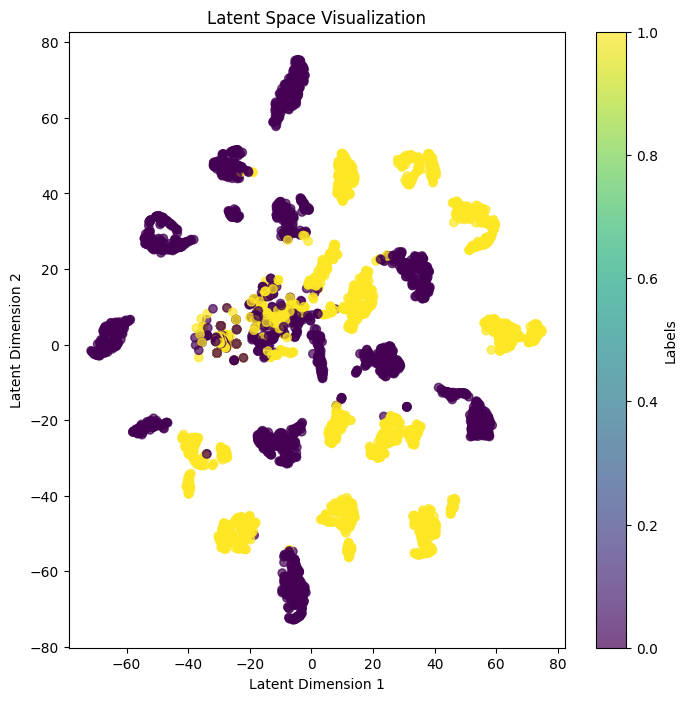

In [16]:
visualize_latent_space(model, dataloader, latent_dim=10, use_tsne=True)

In [17]:
import torch.nn as nn
def extract_latent_features(model, dataloader):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(next(model.parameters()).device)
            mu, _ = model.encode(images)  # Only use mu as the latent representation
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents)
    labels = torch.cat(labels)
    return latents, labels

latent_vectors, target_labels = extract_latent_features(model, dataloader)


In [18]:
latent_features_np = latent_vectors.cpu().numpy()  # Move to CPU and convert to NumPy
target_labels_np = target_labels.cpu().numpy()
np.save("latent_features.npy", latent_features_np)
np.save("target_labels.npy", target_labels_np)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

latent_features = np.load("latent_features.npy")
labels = np.load("target_labels.npy") 

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.25, random_state=42)

# Train a classifier on the latent features
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 91.33%


In [ ]:
import os
from PIL import Image
import torch
import zarr
import numpy as np
sample_ls = ['SQ1631_s1_R', 'SQ1631_s2_R', 'SQ1631_s3_N', 'SQ1631_s4_N',
                 'SQ1632_s1_R', 'SQ1632_s2_N', 'SQ1632_s3_R', 'SQ1632_s4_N',
                 'SQ1633_s1_R', 'SQ1633_s2_R', 'SQ1633_s3_N', 'SQ1633_s4_N',
             'SQ1634_s1_N', 'SQ1634_s2_R', 'SQ1634_s3_R', 'SQ1634_s4_N',
             'SQ1635_s1_N', 'SQ1635_s2_R', 'SQ1635_s3_R', 'SQ1635_s4_N',
             'SQ1636_s1_R', 'SQ1636_s2_N', 'SQ1636_s3_N', 'SQ1636_s4_R']

tile_ls = []
label_ls = []

folder_path = '/home/mass_spec_img/mass_spec_img/data/zarr'
for sample in sample_ls:
    zarr_path = f'{folder_path}/{sample}/slide.zarr'
    slide = zarr.open(zarr_path, mode='r')
    print(f'Zarr dataset loaded from {zarr_path}')
    tile_ls.append(slide)
    if sample.startswith("SQ1631"):
        if "s1" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1632"):
        if "s4" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1633"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(2)
    elif sample.startswith("SQ1634"):
        if "s2" in sample:
            label_ls.append(0)
        else:
            label_ls.append(1)
    elif sample.startswith("SQ1635"):
        if "s3" in sample or "s4" in sample:
            label_ls.append(2)
        elif "s1" in sample:
            label_ls.append(1)
        else:
            label_ls.append(0)
    else:
        if "s4" in sample:
            label_ls.append(1)
        else:
            label_ls.append(2)

In [61]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (500 // 8) * (500 // 8), 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(torch.unique(labels)))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (500 // 8) * (500 // 8))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [37]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

In [39]:
train_size = int(0.7 * len(dataset))  # 70% for training
test_size = len(dataset) - train_size  # Remaining 30% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification

model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

num_classes = 3 # number of classes in the output
model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from tqdm.notebook import tqdm
import torch

criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs).logits  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")


In [64]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

In [65]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, test_loader, criterion, device)
    scheduler.step()  # Update learning rate (if scheduler is used)

Epoch 1/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0025, Train Accuracy: 0.9992


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0014, Test Accuracy: 0.9994
Epoch 2/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0009, Train Accuracy: 0.9997


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0007, Test Accuracy: 0.9998
Epoch 3/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0012, Test Accuracy: 0.9995
Epoch 4/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0010, Test Accuracy: 0.9995
Epoch 5/5


  0%|          | 0/482 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Accuracy: 0.9999


Evaluating:   0%|          | 0/207 [00:00<?, ?it/s]

Test Loss: 0.0002, Test Accuracy: 1.0000


In [47]:
# Dataset implementation for your specific case
class MultiChannelDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.sample_dict = defaultdict(list)
        self.labels = []
        self.samples = []


        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            full_image_path.sort()
            
            for img_path in full_image_path:
                img_array = self._load_image_as_tensor(img_path)
                self.sample_dict[img_path.split("/")[-1][:8]].append(img_array)
        # convert the dictionary into list so we can get the samples by indexing
        for sample in self.sample_dict:
            self.samples.append(self.sample_dict[sample])
            slide_num = sample[:6]
            tissue_num = sample[6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)


        

    def _load_image_as_tensor(self, path):
        """
        Load an image as a NumPy array.
        
        Args:
            path (str): Path to image file
            
        Returns:
            np.ndarray: Image as NumPy array with shape [H, W]
        """
        # Open image using PIL
        with Image.open(path) as img:
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            # Convert to NumPy array
            img_np = np.array(img, dtype=np.float32)
            img_tensor = torch.from_numpy(img_np).unsqueeze(0)
            # transform the tensor if needed
            if self.transform:
                img_tensor = self.transorm(img_tensor)
        return img_tensor
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        
        
        # Stack list of images for each tissue to form a 50-channel tensor
        sample_tensor = torch.stack(sample, dim=0)  # Shape: [50, H, W]
        sample_tensor = sample_tensor.squeeze(1) # remove the color channel for each individual image, so the multidimensional
            
        return sample_tensor, label

In [7]:
class MultiChannelResnet(nn.Module):
    def __init__(self, num_channels=50, num_classes=2):
        """
        Modified ResNet model to handle multi-channel inputs beyond RGB.
        
        Args:
            num_channels (int): Number of input channels (default: 50)
            num_classes (int): Number of output classes (default: 2)
        """
        super(MultiChannelResnet, self).__init__()
        
        # Load a pretrained ResNet model
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Replace the first convolutional layer to accept num_channels instead of 3
        original_layer = self.model.conv1
        new_layer = nn.Conv2d(
            num_channels, 
            original_layer.out_channels,
            kernel_size=original_layer.kernel_size,
            stride=original_layer.stride,
            padding=original_layer.padding,
            bias=(original_layer.bias is not None)
        )
        
        # Initialize the new layer with scaled weights from pretrained model
        with torch.no_grad():
            # Scale the weights to maintain activation magnitude
            scale_factor = 3 / num_channels  # 3 is original RGB channels
            # Only use the first 3 channels for initialization if using pretrained weights
            if num_channels > 3:
                new_layer.weight[:, :3, :, :] = original_layer.weight * scale_factor
                # Initialize remaining channels with small random values
                nn.init.kaiming_normal_(new_layer.weight[:, 3:, :, :], mode='fan_out')
            else:
                new_layer.weight = torch.nn.Parameter(original_layer.weight[:, :num_channels, :, :] * scale_factor)
        
        # Replace the layer
        self.model.conv1 = new_layer
        
        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, num_channels, height, width]
        
        Returns:
            torch.Tensor: Output predictions of shape [batch_size, num_classes]
        """
        return self.model(x)

In [49]:
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v2/'
dataset = MultiChannelDataset(folder_path, transform=None)
# Calculate the sizes for the split
total_size = len(dataset)
train_size = int(0.75 * total_size)  # 75% for training
test_size = total_size - train_size  # 25% for testing


In [ ]:
# Create dataset and dataloadercal

train_dataset, test_dataset = random_split(
        dataset, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )
# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4
)

 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = MultiChannelResnet(num_channels=173, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    # Print epoch training statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate testing metrics
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    # Print testing statistics
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")
    print("-" * 60)

Epoch 1/20
Train Loss: 0.8091 | Train Acc: 50.00%
Test Loss: 2.1426 | Test Acc: 50.00%
------------------------------------------------------------
Epoch 2/20
Train Loss: 1.5373 | Train Acc: 61.11%
Test Loss: 2.2846 | Test Acc: 66.67%
------------------------------------------------------------
Epoch 3/20
Train Loss: 1.1353 | Train Acc: 83.33%
Test Loss: 9.9813 | Test Acc: 50.00%
------------------------------------------------------------
Epoch 4/20
Train Loss: 1.4950 | Train Acc: 77.78%
Test Loss: 17.1982 | Test Acc: 50.00%
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.5543 | Train Acc: 72.22%
Test Loss: 21.7972 | Test Acc: 50.00%
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.6685 | Train Acc: 72.22%
Test Loss: 6.2474 | Test Acc: 50.00%
------------------------------------------------------------
Epoch 7/20
Train Loss: 0.4808 | Train Acc: 77.78%
Test Loss: 4.7533 | Test Acc: 33.33%
-----------------------

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SingleChannelDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Populate image file paths and labels
        for sub_dir in os.listdir(folder_path):
            full_path = os.path.join(folder_path, sub_dir)
            img_names = [f for f in os.listdir(full_path) if f.endswith('.png')]
            full_image_path = [os.path.join(full_path, s) for s in img_names]
            self.image_files.extend(full_image_path)

        # Store tumor type in self.labels (0 = fused glands, 1 = 141541, 2 = solid)
        for img in self.image_files:
            slide_num = img.split("/")[-1].split("_")[0][:6]
            tissue_num = img.split("/")[-1].split("_")[0][6:]
            if slide_num == "SQ1631":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1632":
                if tissue_num == "S1" or tissue_num == "S3":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1633":
                if tissue_num == "S1" or tissue_num == "S2":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
            elif slide_num == "SQ1634" or slide_num == "SQ1635":
                if tissue_num == "S2" or tissue_num == "S3":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
            else:
                if tissue_num == "S1" or tissue_num == "S4":
                    self.labels.append(1)
                else:
                    self.labels.append(0)
                
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        label = self.labels[idx]  # Get the corresponding label
        if self.transform:
            image = self.transform(image)

        return image, label  # Return both image and label

In [ ]:
# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels
    transforms.ToTensor(),           # Convert to tensor
])

# Create dataset and dataloadercal
folder_path = '/home/mass_spec_img/mass_spec_img/data/images_v2/'
dataset = SingleChannelDataset(folder_path, transform=transform)


In [ ]:
tissue_ids = ["SQ1631S1", "SQ1631S2", "SQ1631S3", "SQ1631S4",
              "SQ1632S1", "SQ1632S2", "SQ1632S3", "SQ1632S4",
              "SQ1633S1", "SQ1633S2", "SQ1633S3", "SQ1633S4",
              "SQ1634S1", "SQ1634S2", "SQ1634S3", "SQ1634S4",
              "SQ1635S1", "SQ1635S2", "SQ1635S3", "SQ1635S4",
              "SQ1636S1", "SQ1636S2", "SQ1636S3", "SQ1636S4"]
total_size = len(tissue_ids)
train_size = int(0.8 * len(tissue_ids))  # 80% for training
test_size = len(tissue_ids) - train_size  # 20% for testing
# Create dataset and dataloader
train_ids, test_ids = random_split(
        tissue_ids, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
        )
train_ids, test_ids = list(train_ids), list(test_ids)
train_idx = []
test_idx = []
for i, img_path in enumerate(dataset.image_files):
        tissue_id = img_path.split("/")[-1].split("_")[0]
        if tissue_id in train_ids:
                train_idx.append(i)
        else:
                test_idx.append(i)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)


    

In [19]:

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    num_workers=4
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4
)

 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
model = MultiChannelResnet(num_channels=1, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    
    # Print epoch training statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    
    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate testing metrics
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100.0 * correct / total
    
    # Print testing statistics
    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")
    print("-" * 60)

Epoch 1/20
Train Loss: 0.2924 | Train Acc: 87.34%
Test Loss: 1.2905 | Test Acc: 56.42%
------------------------------------------------------------
Epoch 2/20
Train Loss: 0.1596 | Train Acc: 92.18%
Test Loss: 1.0452 | Test Acc: 58.27%
------------------------------------------------------------
Epoch 3/20
Train Loss: 0.1408 | Train Acc: 92.36%
Test Loss: 1.1259 | Test Acc: 40.81%
------------------------------------------------------------
Epoch 4/20
Train Loss: 0.1406 | Train Acc: 92.76%
Test Loss: 1.1280 | Test Acc: 69.13%
------------------------------------------------------------
Epoch 5/20
Train Loss: 0.1254 | Train Acc: 93.28%
Test Loss: 1.3244 | Test Acc: 51.33%
------------------------------------------------------------
Epoch 6/20
Train Loss: 0.1076 | Train Acc: 93.79%
Test Loss: 0.9707 | Test Acc: 54.10%
------------------------------------------------------------
Epoch 7/20
Train Loss: 0.1113 | Train Acc: 93.70%
Test Loss: 1.4608 | Test Acc: 47.63%
-------------------------